In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

## Reading animelist.csv

In [4]:
import os

In [5]:
INPUT_DIR = os.path.join("..","artifacts", "raw")

In [6]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
len(rating_df)

5000000

## Data Processing

In [9]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [10]:
len(rating_df)

3246641

In [11]:
min_rating = min(rating_df["rating"])
min_rating

0

In [12]:
max_rating = max(rating_df["rating"])
max_rating

10

In [13]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.122732695114736)

In [14]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [15]:
min_rating = min(rating_df["rating"])
min_rating

0.0

In [16]:
max_rating = max(rating_df["rating"])
max_rating

1.0

In [17]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(0.4122732695114729)

In [18]:
rating_df.duplicated().sum()

np.int64(0)

In [19]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [20]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user2user_decoded = {i:x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [21]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [22]:
n_users = len(user2user_encoded)
n_users

4203

In [23]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x:i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [24]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [25]:
rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353
...,...,...,...,...,...
3246636,7916,721,1.0,2005,955
3246637,7516,16067,0.0,1898,1398
3246638,12682,28171,0.8,3208,67
3246639,8387,33255,0.7,2114,1595


In [26]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [27]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [28]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
print("X_train", len(X_train))
print("X_test", len(X_test))

X_train 3245641
X_test 1000


In [30]:
# Converting into list
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Model Architecture

In [31]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs =x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer='Adam')
    return model

In [32]:
model = RecommenderNet()

In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [34]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay **(epoch-ramup_epochs-sustain_epochs)+min_lr

In [35]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True, mode="min")

In [36]:
model_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [37]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=model_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - loss: 0.7992 - mae: 0.3819 - mse: 0.1970 - val_loss: 0.7183 - val_mae: 0.2954 - val_mse: 0.1271 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.7961 - mae: 0.3805 - mse: 0.1956 - val_loss: 0.7730 - val_mae: 0.3177 - val_mse: 0.1475 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.7900 - mae: 0.3783 - mse: 0.1933 - val_loss: 0.7773 - val_mae: 0.3192 - val_mse: 0.1488 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.7823 - mae: 0.3753 - mse: 0.1902 - val_loss: 0.7739 - val_mae: 0.3180 - val_mse: 0.1476 - learning_rate: 3.4000e-05


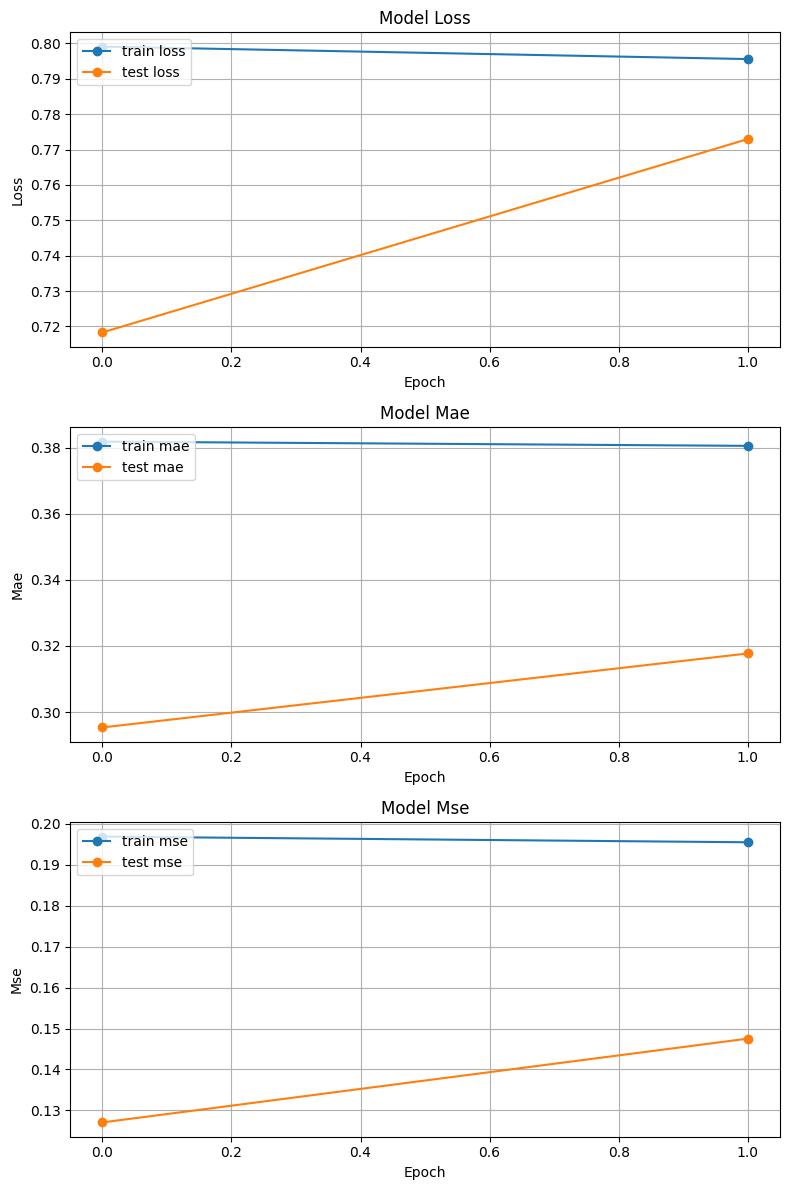

In [38]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [39]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1, 1))
    return weights


In [40]:
anime_weights = extract_weights("anime_embedding", model)

In [41]:
user_weights = extract_weights("user_embedding", model)

## Reading anime.csv

In [42]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [43]:
df = df.replace("Unknown", np.nan)

In [44]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [45]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [46]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [47]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last"
               )

In [48]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [49]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [50]:
def get_anime_frame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [51]:
get_anime_frame("Attack on Titan Final Season", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


## Working with Anime with synopsis

In [52]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [53]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [54]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [55]:
def get_synopsis(anime, df):
    if isinstance(anime, int):
        return df[df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return df[df.Name == anime].sypnopsis.values[0]

In [56]:
get_synopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

## Content/Item based recommendation system

In [57]:
pd.set_option("max_colwidth",None)

In [97]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n = 10, return_dist=False, neg=False):
    try:
        index = get_anime_frame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        similarity_array = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            anime_frame = get_anime_frame(decoded_id, df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            similarity_array.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre" :genre,
            })
        Frame = pd.DataFrame(similarity_array).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)
    except Exception as e:
        print("Error occurred", e)


In [99]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=10,
    
)

,name,similarity,genre
9,Baka to Test to Shoukanjuu Specials,0.344571,"Magic, Comedy, School"
8,In The Beginning:The Bible Stories,0.340365,Historical
7,Crayon Angel,0.332631,Dementia
6,Oniku Daisuki! Zeushi-kun: Suteki na Hamburger,0.325088,Comedy
5,Momoko,0.317295,"Hentai, Romance"
4,Zoids Genesis,0.314206,"Action, Adventure, Comedy, Mecha, Military"
3,Major S1,0.302376,"Comedy, Sports, Drama, Shounen"
2,Otome Hime,0.296438,Hentai
1,Saboten ga Nikui,0.285456,"Music, Comedy, Kids"
0,Bondage House,0.285046,Hentai


### User based Recommendation

In [100]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        similarity_arr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                similarity_arr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        similar_users = pd.DataFrame(similarity_arr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error occurred", e)

In [101]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,8774,0.307957
8,15233,0.286424
7,8940,0.282202
6,13970,0.265552
5,8155,0.264197
4,14808,0.259797
3,10543,0.258787
2,8012,0.251785
1,4524,0.251438
0,7986,0.249611


In [102]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [103]:
from collections import defaultdict

In [104]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [106]:
def get_fav_genre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [79]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1


In [107]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        get_fav_genre(anime_df_rows,plot)


    return anime_df_rows




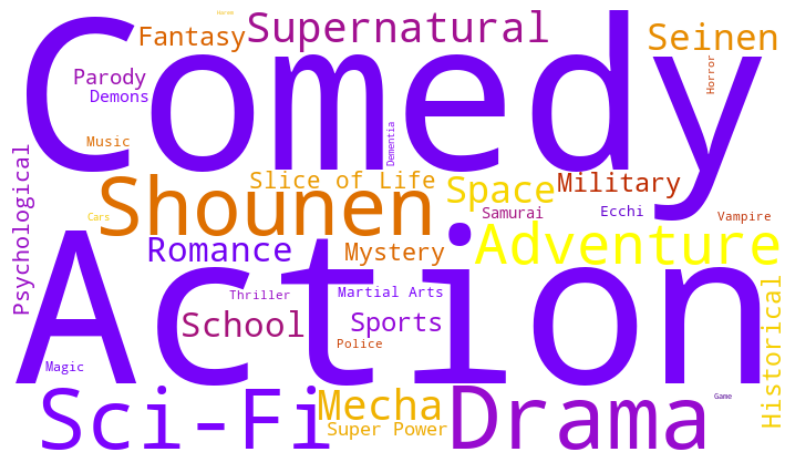

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
833,Gintama,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"


In [108]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [109]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = get_anime_frame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = get_synopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [110]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
similar_users

,similar_users,similarity
9,8774,0.307957
8,15233,0.286424
7,8940,0.282202
6,13970,0.265552
5,8155,0.264197
4,14808,0.259797
3,10543,0.258787
2,8012,0.251785
1,4524,0.251438
0,7986,0.249611


In [111]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [112]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,8,Re:ZERO -Starting Life in Another World-,"Psychological, Drama, Thriller, Fantasy","hen Subaru Natsuki leaves the convenience store, the last thing he expects is to be wrenched from his everyday life and dropped into a fantasy world. Things aren't looking good for the bewildered teenager; however, not long after his arrival, he is attacked by some thugs. Armed with only a bag of groceries and a now useless cell phone, he is quickly beaten to a pulp. Fortunately, a mysterious beauty named Satella, in hot pursuit after the one who stole her insignia, happens upon Subaru and saves him. In order to thank the honest and kindhearted girl, Subaru offers to help in her search, and later that night, he even finds the whereabouts of that which she seeks. But unbeknownst to them, a much darker force stalks the pair from the shadows, and just minutes after locating the insignia, Subaru and Satella are brutally murdered. However, Subaru immediately reawakens to a familiar scene—confronted by the same group of thugs, meeting Satella all over again—the enigma deepens as history inexplicably repeats itself."


### HYBRID RECOMMENDER SYSTEM

In [95]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [113]:
hybrid_recommendation(11880)

['Re:ZERO -Starting Life in Another World-',
 'Angel Beats!',
 'Your Name.',
 "KonoSuba:God's Blessing on This Wonderful World!",
 'anohana:The Flower We Saw That Day',
 'Aldnoah.Zero',
 'Fate/Zero',
 'Sword Art Online',
 'No Game, No Life',
 'Attack on Titan']